# Basic Configuration

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop3.2.tgz
!tar -xvf spark-3.0.0-preview2-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
!pip install scikit-surprise
!pip install seaborn

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop3.2"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.sparkContext.setCheckpointDir('/content/drive/My Drive/thesis/checkpoint/')

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import StructField, StructType, StringType, FloatType

In [ ]:
import sys
import pandas as pd
sys.path.append('/content/drive/My Drive/thesis')

In [ ]:
from surprise import dump, Reader, Dataset, SVD, KNNBasic
from surprise.model_selection import train_test_split, cross_validate
from surprise.accuracy import rmse, mae
from tuning.GSCV import get_best_params
from util.util import filter_users, filter_products, precision_recall_at_k
from algo.IncrementalSVD import IncrementalSVD

In [ ]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
%matplotlib inline
import seaborn as sns
plt.rcParams["axes.labelsize"] = 12
plt.style.use('default')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Helper Functions

In [ ]:
from collections import defaultdict

class Recommender:
    def __init__(self, model_path):
        # load prediction and model from a given file
        self.predictions, self.model = dump.load(model_path)
        self.user_ratings = defaultdict(set)

    def recommend(self, raw_uid, k=50, exclude_test=False):
        recommendations = []
        # get all the items from saved trainset
        for iid in self.model.trainset.all_items():
          if exclude_test:
            # if user has rated the product, skip it
            uid = self.model.trainset.to_inner_uid(raw_uid)
            if uid in self.user_ratings and iid in self.user_ratings[uid]:
              continue

          rid = self.model.trainset.to_raw_iid(iid)
          prediction = self.model.predict(raw_uid, rid)

          # only consider rating that are larger or equal than 3
          #if prediction.est >= 3:
          recommendations.append((rid, prediction.est))

        recommendations.sort(key=lambda x: x[1], reverse=True)
        return recommendations[:k]

    def map_user_rating(self):
      for uid, ratings in self.model.trainset.ur.items():
        self.user_ratings[uid] = set([r[0] for r in ratings])

    def get_neighbors(self, raw_id, user_based=False, k=50):
      """Returns Top-K neighbors of a user of item.
      Args:
          raw_id: User/item raw id
          k: Number of neighbors
      """
      if user_based:
          to_inner = self.model.trainset.to_inner_uid
          to_raw = self.model.trainset.to_raw_uid
      else:
          to_inner = self.model.trainset.to_inner_iid
          to_raw = self.model.trainset.to_raw_iid

      inner_id = to_inner(raw_id)
      inner_neighbors = self.model.get_neighbors(inner_id, k=k)

      raw_neighbors = [to_raw(iid) for iid in inner_neighbors]
  
      return raw_neighbors

    def compute_precision_recall_at_k(self, k=20, threshold=3):
      precisions, recalls = precision_recall_at_k(self.predictions, k=k, threshold=threshold)
      
      self.avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
      self.avg_recall = sum(rec for rec in recalls.values()) / len(recalls)

      return self.avg_precision, self.avg_recall

    def compute_f1(self):
      return 2 * (self.avg_precision * self.avg_recall) / (self.avg_precision + self.avg_recall)

## Constants

In [ ]:
# constant for consistent evaluation

# the answer of the universe
SEED = 42

# number of records to use
NROWS = 100000

# number of recommendation products
N_REC = 50

# traint set ratio
TEST_SIZE = 0.2

# number of K to compute precision and recall @k
K = 20
KS = [5, 10, 15, 20, 50]

# threshold of a rating to be considered "relevant"
THRESHOLD = 4

# user to generate recommendation on
RUID = 'tisu1902'

# drive path
FILE_PATH = 'drive/My Drive/thesis'

In [ ]:
data_path = FILE_PATH + '/data/3M_20.csv'

# Data Pre-processing

In [ ]:
def remove_noise(df, threshold=20, drop_count=True):
  # filter items that has number of ratings less than threshold
  df_item_count = df.groupby('asin').overall.count().reset_index().rename(columns={'overall':'num_item'})
  # same for user
  df_user_count = df.groupby('reviewerID').overall.count().reset_index().rename(columns={'overall':'num_user'})

  df_count = df.merge(df_item_count, on='asin').merge(df_user_count, on='reviewerID')
  df_clean = df_count[(df_count.num_item.astype('int') >= 20) | (df_count.num_user.astype('int') >= 20)]

  if drop_count:
    df_clean.drop(columns=['num_item', 'num_user'], axis=1, inplace=True)

  return df_clean

In [ ]:
df = pd.read_csv('drive/My Drive/thesis/data/ratings_droptime.csv', header=0, nrows=3000000)

In [ ]:
df['reviewerID'].nunique(), df['asin'].nunique()

(1928027, 163801)

In [ ]:
df_clean = remove_noise(df)
# df_clean.to_csv(data_path, index=False)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_clean['reviewerID'].nunique(), df['asin'].nunique()

(1658040, 163801)

In [ ]:
df_clean.to_csv('rating.csv', index=False)

## **Scikit-surprise Dataset**

In [ ]:
# load data from csv
sp_data = pd.read_csv('rating.csv', header=0)

# convert to surprise Dataset
reader = Reader()
sp_raw_data = Dataset.load_from_df(sp_data, reader=reader)
sp_train, sp_test = train_test_split(sp_raw_data, test_size=TEST_SIZE, random_state=SEED)

# build full trainset, testset for top-N recommendation
sp_train_set = sp_raw_data.build_full_trainset()
sp_test_set = sp_train_set.build_testset()

In [ ]:
n_ratings = len(sp_data)
n_users = sp_data['reviewerID'].nunique()
n_items = sp_data['asin'].nunique()

print(f'Number of ratings: {n_ratings}')
print(f'Number of users:  {n_users}')
print(f'Number of items: {n_items}')

Number of ratings: 2460523
Number of users:  1658040
Number of items: 39798


## **Convert to JSON for NodeJS Back-end**

In [ ]:
# This block of code is used to read data from gzip.json file.

import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

# get df from gzip file
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

### Get users' ratings.

In [ ]:
from collections import defaultdict
users_dict = []

for inner_uid, ratings in sp_train_set.ur.items():
  raw_uid = sp_train_set.to_raw_uid(inner_uid)
  raw_ratings = [{'asin': sp_train_set.to_raw_iid(inner_iid), 'overall': rating} for inner_iid, rating in ratings]

  users_dict.append({'reviewerID': raw_uid, 'password': '$2b$10$oJXBsr2mAdjEnMPSE8jFxe952DPH5NVjGp5UoEFQ5vfrn0JprgRfG', 'ratings':raw_ratings})


In [ ]:
# save 
import json

with open(FILE_PATH + '/data/users_final.json', 'w') as fout:
    json.dump(users_dict , fout)

### Filter and get the data that in train set.

**Get full information products**

In [ ]:
# get full product information  
df = getDF(FILE_PATH + '/data/json_part/products_full.gz')

rated_products = set(sp_data['asin'].unique())
all_products = set(df['asin'].unique())
rated_products_df = df.query('asin in @rated_products').drop('salesRank', axis=1)
rated_products_df.head()

# save
# rated_products_df.to_json(FILE_PATH + '/data/products.json', orient='records')

,asin,imUrl,description,categories,title,price,related,brand
20,0594481813,http://ecx.images-amazon.com/images/I/41K7ymN5...,Power up your device with this Barnes &amp; No...,"[[Electronics, eBook Readers & Accessories, Po...",Barnes &amp; Noble OV/HB-ADP Universal Power Kit,19.65,"{'also_bought': ['B00AAKLIIS', 'B00A668GUO', '...",Barnes &amp; Noble
38,0972683275,http://ecx.images-amazon.com/images/I/41hYJ9Mw...,The VideoSecu TV mount is a mounting solution ...,"[[Electronics, Accessories & Supplies, Audio &...",VideoSecu 24&quot; Long Arm TV Wall Mount Low ...,29.99,"{'also_bought': ['B000X3KOD2', 'B0074FGR74', '...",VideoSecu
53,1400532620,http://ecx.images-amazon.com/images/I/519ca3cu...,Barnes & Noble Nook eReader - no 3GMeet nook. ...,"[[Electronics, eBook Readers & Accessories]]",Barnes &amp; Noble Nook eReader - no 3G,74.95,"{'also_bought': ['B0035CLBT4', 'B004X18N24', '...",Barnes &amp; Noble
54,140053271X,http://ecx.images-amazon.com/images/I/51jat7CV...,Barnes & Noble Nook Simple Touch Wi-Fi ReaderI...,"[[Electronics, eBook Readers & Accessories, eB...",Barnes &amp; Noble Nook Simple Touch eBook Rea...,79.49,"{'also_bought': ['B007UXNHNM', 'B007UXNHGY', '...",Barnes &amp; Noble
57,1400698987,http://ecx.images-amazon.com/images/I/51lnBzuR...,The Nook HD Tablet has an amazing combination ...,"[[Electronics, Computers & Accessories, Tablets]]",Nook HD 7&quot; 8GB Tablet,158.99,"{'also_bought': ['B00AAKLIIS', 'B00E9IAQ1C', '...",Barnes &amp; Noble


**Get full information users**

In [ ]:
df = getDF(FILE_PATH + '/data/json_part/ratings_with_text.json.gz')

rated_users = set(sp_data['reviewerID'].unique())
rated_users_df = df.query('reviewerID in @rated_users')
rated_users_df.head()

# rated_users_df.to_json(FILE_PATH + '/data/json/reviews.json', orient='records')

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
15,AT09WGFUM934H,0594481813,John,"[0, 0]",It does 2A and charges a DEAD Nook in a few ho...,3.0,This is the oem charger you get with the nook hd+,1377907200,"08 31, 2013"
21,A3BMUBUC1N77U8,0972683275,ahoffoss,"[0, 0]",This mount works really well once you get it u...,4.0,"Pretty simple, but definitely good!",1385164800,"11 23, 2013"
57,A6J8D9V5S9MBE,0972683275,Curtis G,"[0, 0]",In the process of turning our master bedroom i...,5.0,Simple and effective. Just the way I like it.,1306886400,"06 1, 2011"
58,A39Z4OU2C7ENWH,0972683275,Dave C,"[1, 1]",I gave this mount 3 stars.5 to start because o...,3.0,"Works, but I don't trust it",1328572800,"02 7, 2012"
104,A3TAS1AG6FMBQW,0972683275,"Jeri Zerr ""formerly a Road Warrior of the Nth...","[0, 0]",The VideoSecu line of articulating wall mounts...,5.0,"High quality construction, comes with plenty o...",1353456000,"11 21, 2012"


In [ ]:
# merge with the reviews dataframe to get the `reviewerName` column
users_df = pd.DataFrame(users_dict)
users_df.sort_values(by='reviewerID', ascending=False)

reviewer_name = rated_users_df.sort_values(by='reviewerID', ascending=False)[['reviewerID', 'reviewerName']].drop_duplicates()
users_with_name = users_df.merge(reviewer_name, on='reviewerID', how='outer').fillna('Amazon Customer').drop_duplicates(['reviewerID']).reset_index(drop=True)

# only get needed columns
users_with_name.columns = ['username', 'password', 'ratings', 'name']

# save
users_with_name.to_json(FILE_PATH + '/data/json/users.json', orient='records')

**Get full text reviews**


In [ ]:
# change column name and drop unnecessary columns
rated_users_df.rename(columns={'reviewerID':'username'}, inplace=True)
rated_users_df.drop('reviewerName', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# get all unique products and users
rated_products = set(sp_data['asin'].unique())
rated_users = set(sp_data['reviewerID'].unique())

In [ ]:
review_json = rated_users_df.query('(asin in @rated_products) & (username in @rated_users)').reset_index(drop=True)
# review_json.to_json(FILE_PATH + '/data/json/reviews.json', orient='records')

In [ ]:
review_json

,username,asin,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AT09WGFUM934H,0594481813,"[0, 0]",It does 2A and charges a DEAD Nook in a few ho...,3.0,This is the oem charger you get with the nook hd+,1377907200,"08 31, 2013"
1,A3BMUBUC1N77U8,0972683275,"[0, 0]",This mount works really well once you get it u...,4.0,"Pretty simple, but definitely good!",1385164800,"11 23, 2013"
2,A6J8D9V5S9MBE,0972683275,"[0, 0]",In the process of turning our master bedroom i...,5.0,Simple and effective. Just the way I like it.,1306886400,"06 1, 2011"
3,A39Z4OU2C7ENWH,0972683275,"[1, 1]",I gave this mount 3 stars.5 to start because o...,3.0,"Works, but I don't trust it",1328572800,"02 7, 2012"
4,A3TAS1AG6FMBQW,0972683275,"[0, 0]",The VideoSecu line of articulating wall mounts...,5.0,"High quality construction, comes with plenty o...",1353456000,"11 21, 2012"
...,...,...,...,...,...,...,...,...
60927,A2NUWASJTPN7RO,B0031GGQC6,"[0, 0]","Just as good as the name brand parts, but so m...",5.0,Excellent excellent excellent,1361318400,"02 20, 2013"
60928,ADOR3TR7GDF68,B0031GGQC6,"[0, 0]",Package was opened once and resealed. I know t...,1.0,Buyer Beware!,1394236800,"03 8, 2014"
60929,A21VM9WVF8EOSJ,B0031GGQC6,"[1, 1]",Memory modules (sticks) received were not the ...,2.0,Modules are different from picture,1378857600,"09 11, 2013"
60930,A3V0YR50F1XSKP,B0031GGQC6,"[0, 0]",I installed this memory into a Dell computer. ...,5.0,Seems to work well.,1376092800,"08 10, 2013"


## **PySpark DataFrame**

In [ ]:
# Load from CSV and use StringIndexer to fit and transform on the raw data
schema = StructType([
    StructField("reviewerID", StringType()),
    StructField("asin", StringType()),
    StructField("overall", FloatType())])
ps_raw_data = spark.read.load(data_path, format='csv', header=True, schema=schema)

# index all columns except "overall"
indexer = [StringIndexer(inputCol=column, outputCol=column + "_index") for column in
               list(set(ps_raw_data.columns) - {'overall'})]

pipeline = Pipeline(stages=indexer)
ps_data = pipeline.fit(ps_raw_data).transform(ps_raw_data)

ps_train_set, ps_test_set  = ps_data.randomSplit([0.8, 0.2], seed=0)
ps_train_set.show()

+--------------+----------+-------+----------+----------------+
|    reviewerID|      asin|overall|asin_index|reviewerID_index|
+--------------+----------+-------+----------+----------------+
|A100UD67AHFODS|B00004Z5M1|    5.0|     214.0|           370.0|
|A100UD67AHFODS|B000069EUW|    5.0|     866.0|           370.0|
|A100UD67AHFODS|B000069JWX|    1.0|    4818.0|           370.0|
|A100UD67AHFODS|B0000AR0I4|    5.0|   10448.0|           370.0|
|A100UD67AHFODS|B0001D3K8A|    5.0|     536.0|           370.0|
|A100UD67AHFODS|B000233WJ6|    5.0|     250.0|           370.0|
|A100UD67AHFODS|B0002KVQBA|    5.0|     252.0|           370.0|
|A100UD67AHFODS|B0002SQ2P2|    5.0|     155.0|           370.0|
|A100UD67AHFODS|B000ERAOL4|    5.0|   11582.0|           370.0|
|A100UD67AHFODS|B000H0K8VY|    5.0|    7846.0|           370.0|
|A100UD67AHFODS|B000HZDF8W|    5.0|     321.0|           370.0|
|A100UD67AHFODS|B000LRMS66|    5.0|       9.0|           370.0|
|A100UD67AHFODS|B000OMKR8E|    2.0|     

# Train and test model

## SVD

In [ ]:
from algo.IncrementalSVD import IncrementalSVD

svd_param_grid = {'n_epochs': [20, 50, 100],
              'n_factors': [20, 50, 100],
              'lr_all': [.005, .1, .5],
              'reg_all': [.001, .1, .6],
              }

svd_best_params = get_best_params(sp_data, IncrementalSVD, svd_param_grid, ('rmse', 'mae'))
svd_best_params

{'mae': {'lr_all': 0.5, 'n_epochs': 100, 'n_factors': 20, 'reg_all': 0.1},
 'rmse': {'lr_all': 0.005, 'n_epochs': 20, 'n_factors': 20, 'reg_all': 0.1}}

In [ ]:
insvd = IncrementalSVD(n_factors=20, n_epochs=100, lr_all=0.005, reg_all=.1, random_state=SEED)
insvd.fit(sp_train)
svd_predictions = insvd.test(sp_test)
# cross_validate(svd_model, sp_train_set, measures=['RMSE', 'MAE'], cv=5, verbose=True)
rmse(svd_predictions)
mae(svd_predictions)

RMSE: 1.0677
MAE:  0.7750


0.7749645598086929

In [ ]:
for k in range(5, 50, 5):
  precisions, recalls = precision_recall_at_k(svd_predictions, k=k, threshold=3)
  avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
  avg_recall = sum(rec for rec in recalls.values()) / len(recalls)
  print(avg_precision, avg_recall)


0.9109240246406546 0.8685556508702026
0.9069971643688274 0.9595503774545507
0.9066111985208489 0.9707073018605884
0.9064043375063328 0.9733121582525034
0.906361905456937 0.9739263557724632
0.9063482162030013 0.9743309762417133
0.9063321240176039 0.974580784274505
0.9063354711154068 0.9747859729820713
0.9063229226326326 0.9748860349096486


## User-based KNN

In [ ]:
u_knn_param_grid = {
    'sim_options': {
        'name': ['msd', 'cosine'],
    },
    'k': [5, 50, 100],
}

u_knn_best_params = get_best_params(sp_data, KNNBasic, u_knn_param_grid, ('rmse', 'mae'))
u_knn_best_params

In [ ]:
user_knn = KNNBasic(k=50, sim_options={'name':'cosine', 'user_based': True}, random_state=SEED)
user_knn_model = user_knn.fit(sp_train)
u_knn_predictions = user_knn_model.test(sp_test)
u_knn_rmse = ('user-knn', rmse(u_knn_predictions))
u_knn_mae = ('user-knn', mae(u_knn_predictions))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2180
MAE:  0.8656


## Item-based KNN

In [ ]:
i_knn_param_grid = {
    'sim_options': {
        'name': ['msd', 'cosine'],
        'user_based': [False]
    },
    'k': [5, 50, 100],
}

i_knn_best_params = get_best_params(sp_data, KNNBasic, i_knn_param_grid, ('rmse', 'mae'))
i_knn_best_params

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix.

{'mae': {'k': 5, 'sim_options': {'name': 'msd', 'user_based': False}},
 'rmse': {'k': 50, 'sim_options': {'name': 'cosine', 'user_based': False}}}

In [ ]:
item_knn = KNNBasic(k=50, sim_options={'name':'cosine', 'user_based': False}, random_state=SEED)
item_knn_model = item_knn.fit(sp_train)
i_knn_predictions = item_knn_model.test(sp_test)
i_knn_rmse = ('item-knn', rmse(i_knn_predictions))
i_knn_mae = ('item-knn', mae(i_knn_predictions))

In [ ]:
# train on full dataset
item_knn = KNNBasic(k=50, sim_options={'name':'cosine', 'user_based': False}, random_state=SEED)
item_knn_model = item_knn.fit(sp_train_set)
i_knn_predictions = item_knn_model.test(sp_test_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0104
MAE:  0.7479


In [ ]:
dump.dump(file_name='/content/drive/My Drive/thesis/model/iknn', algo=item_knn_model, predictions=i_knn_predictions)

In [ ]:
sp_train_set.n

## ALS

In [ ]:
# create model
als = ALS(userCol='reviewerID_index', itemCol='asin_index', ratingCol='overall', coldStartStrategy='drop', nonnegative=True)
als.setParams(maxIter=100, alpha=0.01, seed=SEED, intermediateStorageLevel='DISK_ONLY', checkpointInterval=2)

ALS_37d8cf942061

In [ ]:
# fit on train set
als_model = als.fit(ps_train_set)
als_predictions = als_model.transform(ps_test_set)
als_predictions.show()

+--------------+----------+-------+----------+----------------+----------+
|    reviewerID|      asin|overall|asin_index|reviewerID_index|prediction|
+--------------+----------+-------+----------+----------------+----------+
| ARBKYIVNYWK3C|B001HSOFI2|    4.0|     148.0|            12.0|  4.395274|
| AUCISQA1YXX86|B001HSOFI2|    2.0|     148.0|           190.0| 3.2120821|
|A16QODENBJVUI1|B001HSOFI2|    5.0|     148.0|           218.0|  4.709475|
|A1SB9BNNGKNX2Z|B001HSOFI2|    5.0|     148.0|           154.0|  4.826957|
|A195EZSQDW3E21|B001HSOFI2|    5.0|     148.0|          1451.0| 3.3078709|
|A18S2VGUH9SCV5|B001HSOFI2|    5.0|     148.0|            80.0| 4.0290327|
|A3OKH5G69MS8D9|B001HSOFI2|    5.0|     148.0|          1389.0| 4.1914177|
|A225G2TFM76GYX|B001HSOFI2|    4.0|     148.0|            95.0| 4.2767096|
|A3AGWRMHKLFLWR|B001HSOFI2|    4.0|     148.0|          1730.0|  3.949614|
|A2S549B4743R0S|B001HSOFI2|    5.0|     148.0|          1184.0| 3.6809363|
|A2WLNSZ9U0T1S3|B001HSOFI

## Save models

In [ ]:
model_path = '/content/drive/My Drive/thesis/model/clean/'
dump.dump(file_name=model_path + 'insvd', algo=insvd, predictions=svd_predictions)
# dump.dump(file_name=model_path + 'iknn_3M', algo=item_knn_model, predictions=i_knn_predictions)
# dump.dump(file_name=model_path + 'uknn_3M', algo=user_knn_model, predictions=u_knn_predictions)
# als_model.save(model_path + 'als_3M')

# Load Models and Evaluate

In [ ]:
item_knn = RecSys('/content/drive/My Drive/thesis/model/iknn')
svd = RecSys('/content/drive/My Drive/thesis/model/insvd')
user_knn = RecSys('/content/drive/My Drive/thesis/model/clean/uknn_3M')

# als = ALSModel.load('/content/drive/My Drive/thesis/model/clean/als_3M')

ModuleNotFoundError: ignored

## 1. Alternating Least Squares

### **Helper functions for modeling**

In [ ]:
def uid_to_ruid(df, uid):
  '''
  Convert user index to raw "reviewerID"
  '''
  user_row = df[df['reviewerID_index'].isin([uid])]

  if user_row.count():
    return user_row.collect()[0].reviewerID

  return False

def iid_to_riid(df, iid):
  '''
  Convert item index to "asin"
  '''
  item_row = df[df['asin_index'].isin([iid])]

  if item_row.count():
    return item_row.collect()[0].asin
  
  return False

def riid_to_iid(df, rid):
  item_row = df[df['asin'].isin([rid])]

  if item_row.count():
    return item_row.collect()[0]['asin_index']

  return False

def ruid_to_uid(df, ruid):
  user_row = df[df['reviewerID'].isin([ruid])]

  if user_row.count():
    return user_row.collect()[0]['reviewerID_index']

  return False

def als_recommend(model, df, ruid, k=10):
  uid = ruid_to_uid(df, ruid)
  user_row = df.filter(df['reviewerID_index'] == uid).select('reviewerID_index').distinct()

  if user_row.count():
      rec_dict = model.recommendForUserSubset(user_row, k).collect()[0].asDict()['recommendations']
      rec_list = set()

      for rec in rec_dict:
        rec_list.add((iid_to_riid(df, rec[0]), rec[1]))
      
      return rec_list
      
  return False

def pyspark_precision_recall_at_k(predictions, k=K, threshold=THRESHOLD):
  precisions = dict()
  recalls = dict()

  for uid, user_ratings in predictions.items():
    # number of relevant items
    n_rel = sum((overall >= threshold) for (_, overall) in user_ratings)

    # number of recommended item in top K
    n_rec = sum((prediction >= threshold) for (prediction, _) in user_ratings[:k])

    # number of relevant and recommended in top K
    n_rel_and_rec = sum((overall >= threshold) and (prediction >= threshold) for (prediction, overall) in user_ratings[:k])

    # precision@k = proportion of recommended items that are relevant
    precisions[uid] = n_rel_and_rec / n_rec if n_rec != 0 else 1

    # recall@k = proportion of relevant items that are recommended
    recalls[uid] = n_rel_and_rec / n_rel if n_rel != 0 else 1

  als_precision = sum(prec for prec in precisions.values()) / len(precisions)
  als_recall = sum(rec for rec in recalls.values()) / len(recalls)
  als_f1 = 2 * (als_precision * als_recall) / (als_precision + als_recall)

  return als_precision, als_recall, als_f1

### **RMSE and MAE**

In [ ]:
# some processing for ALS
als_preds = als.transform(ps_test_set)

# rmse
evaluator = RegressionEvaluator(metricName='rmse', labelCol='overall', predictionCol='prediction')
als_rmse = evaluator.evaluate(als_preds)

# mae
evaluator = RegressionEvaluator(metricName='mae', labelCol='overall', predictionCol='prediction')
als_mae = evaluator.evaluate(als_preds)

als_rmse, als_mae

(1.3299290852331167, 1.0388675367951883)

In [ ]:
als_preds.toPandas().to_csv(FILE_PATH + '/data/dataframe/als_prediction.csv', index=False)

### **Precision and Recall @K**

In [ ]:
als_preds.cache()

DataFrame[reviewerID: string, asin: string, overall: float, reviewerID_index: double, asin_index: double, prediction: float]

In [ ]:
pred_df = pd.read_csv('/content/drive/My Drive/thesis/data/dataframe/als_prediction.csv', header=0)

In [ ]:
# pred_df = als_preds.toPandas()
# pred_df.head()
# pred_df.to_csv('/content/drive/My Drive/thesis/data/dataframe/als_prediction.csv', index=False)

In [ ]:
from collections import defaultdict

# ALS
user_est = defaultdict(list)
for index, row in pred_df.iterrows():
    user_est[row.reviewerID].append((row.prediction, row.overall))

als_scores = set()

for k in KS:
  precision, recall, f1 = pyspark_precision_recall_at_k(user_est, k)
  als_scores.add(('als',k, precision, recall, f1))

als_scores

{('als', 5, 0.919164602257088, 0.44560518402435184, 0.6002250575218644),
 ('als', 10, 0.9163491408123942, 0.4846737055742651, 0.6340086956080436),
 ('als', 15, 0.9166223262011869, 0.4890821620858448, 0.6378348121530556),
 ('als', 20, 0.916076604490106, 0.49038728288338235, 0.6388110224825755),
 ('als', 50, 0.9159598034972092, 0.49119087043959975, 0.6394639913133895)}

In [ ]:
als_scores_df = pd.DataFrame(als_scores, columns=['name', 'k', 'precision', 'recall', 'f1'])
als_scores_df.head()

,name,k,precision,recall,f1
0,als,20,0.916077,0.490387,0.638811
1,als,5,0.919165,0.445605,0.600225
2,als,50,0.915960,0.491191,0.639464
3,als,10,0.916349,0.484674,0.634009
4,als,15,0.916622,0.489082,0.637835


In [ ]:
als_scores_df.to_csv(FILE_PATH + '/data/dataframe/p_and_r_als.csv', index=False)

### **Recommendation for a user**

In [ ]:
als_rec_set = als_recommend(als, ps_data, RUID, N_REC)
als_rec_list = [rec[0] for rec in als_rec_set]
print(als_rec_set)

{('B00006B8EN', 4.759439468383789), ('B00008Z1PB', 4.711718559265137), ('B00006B7RS', 4.683365821838379), ('B00006364O', 4.820785045623779), ('B00009UHBS', 4.773634433746338), ('B00009V4G4', 4.909791469573975), ('B000070GUZ', 4.8081793785095215), ('B000068O34', 4.77763032913208), ('B00004Y2MM', 5.102606296539307), ('B00009R6WY', 4.740819931030273), ('B00006I5AF', 4.9679741859436035), ('B00008RUL6', 4.956148147583008), ('B00006ID3V', 4.692884922027588), ('B000052WM4', 4.685394287109375), ('B000063EN0', 4.703600883483887), ('B00005OMMN', 4.966607093811035), ('B000068O5D', 4.7315168380737305), ('B00004WLJ4', 4.784207344055176), ('B00003G1RG', 4.796334266662598), ('B00005MJ9L', 4.8968682289123535), ('B00004T8R2', 4.7817840576171875), ('B000069V27', 4.685791969299316), ('B00004Z68P', 4.729735851287842), ('B0000635UW', 5.016861915588379), ('B00005B4BJ', 5.150888442993164), ('B00008AOKJ', 4.808311462402344), ('B00006B81J', 4.76770544052124), ('B00005N5WR', 4.887773513793945), ('B00009R6X4', 4

In [ ]:
als_rec_df = pd.DataFrame(als_rec_set, columns=['product', 'score'])
als_rec_df.sort_values(by='score', inplace=True, ascending=False)
als_rec_df.head(10)

,product,score
36,B00006HPIN,5.268854
40,B00006BC1X,5.257048
24,B00005B4BJ,5.150888
8,B00004Y2MM,5.102606
39,B0000206GE,5.019721
23,B0000635UW,5.016862
42,B00009UH6Z,5.011799
28,B00009R6X4,4.970414
10,B00006I5AF,4.967974
15,B00005OMMN,4.966607


## 2. Other algorithms

### **RMSE and MAE**

In [ ]:
user_knn_rmse = rmse(user_knn.predictions)
item_knn_rmse = rmse(item_knn.predictions)
svd_rmse = rmse(svd.predictions)

user_knn_mae = mae(user_knn.predictions)
item_knn_mae = mae(item_knn.predictions)
svd_mae = mae(svd.predictions)

RMSE: 1.2180
RMSE: 1.1854
RMSE: 1.0677
MAE:  0.8656
MAE:  0.8367
MAE:  0.7750


### **Precision and Recall @K**

In [ ]:
item_knn_scores = set()
user_knn_scores = set()
svd_scores = set()

for k in KS:
  item_knn_p, item_knn_r = item_knn.compute_precision_recall_at_k(k, THRESHOLD)
  user_knn_p, user_knn_r = user_knn.compute_precision_recall_at_k(k, THRESHOLD)
  svd_p, svd_r = svd.compute_precision_recall_at_k(k, THRESHOLD)

  item_knn_scores.add(('item-knn', k, item_knn_p, item_knn_r, item_knn.compute_f1()))
  user_knn_scores.add(('user-knn', k, user_knn_p, user_knn_r, user_knn.compute_f1()))
  svd_scores.add(('svd', k, svd_p, svd_r, svd.compute_f1()))

print(item_knn_scores)
print(user_knn_scores)
print(svd_scores)

{('item-knn', 15, 0.8133779407906714, 0.9080385808158817, 0.8581055680042033), ('item-knn', 50, 0.81323004917092, 0.9111482456107733, 0.85940902274446), ('item-knn', 20, 0.8131759748499308, 0.9096835440840554, 0.8587267790971129), ('item-knn', 5, 0.8139356605064993, 0.8211197050329033, 0.8175119002779139), ('item-knn', 10, 0.813384505068283, 0.8994824867726506, 0.8542696202404298)}
{('user-knn', 5, 0.8248117727583821, 0.8376751967759881, 0.8311937196621079), ('user-knn', 15, 0.8220112137463271, 0.9184158538320002, 0.8675435412329746), ('user-knn', 10, 0.8223876340406121, 0.9109924999130096, 0.8644254678555671), ('user-knn', 50, 0.821884007799732, 0.9208709338517924, 0.8685662862767888), ('user-knn', 20, 0.821916012331347, 0.9196924822620135, 0.8680595896707611)}
{('svd', 5, 0.8772142368240915, 0.7016179601931003, 0.7796512696607548), ('svd', 15, 0.8740175783604942, 0.7611990772459892, 0.813716484434938), ('svd', 10, 0.8740508783937944, 0.755257420982939, 0.8103235127152957), ('svd', 50

In [ ]:
columns = ['name', 'k', 'precision', 'recall', 'f1']
item_knn_scores_df = pd.DataFrame(item_knn_scores, columns=columns)
user_knn_scores_df = pd.DataFrame(user_knn_scores, columns=columns)
svd_scores_df = pd.DataFrame(svd_scores, columns=columns)

In [ ]:
item_knn_scores_df.to_csv(FILE_PATH + '/data/dataframe/item_knn_accuracy.csv', index=False)
user_knn_scores_df.to_csv(FILE_PATH + '/data/dataframe/user_knn_accuracy.csv', index=False)
svd_scores_df.to_csv(FILE_PATH + '/data/dataframe/svd_accuracy.csv', index=False)

### **Recommendation for a user**

In [ ]:
i_knn_rec_set = item_knn.recommend(RUID, N_REC)
u_knn_rec_set = user_knn.recommend(RUID, N_REC)
svd_rec_set = svd.recommend(RUID, N_REC)

i_knn_rec = [item[0] for item in i_knn_rec_set]
u_knn_rec = [item[0] for item in u_knn_rec_set]
svd_rec = [item[0] for item in svd_rec_set]

columns = ['product', 'rating']

In [ ]:
# Item-based KNN recommendations
pd.DataFrame(i_knn_rec_set, columns=columns).head(10)

,product,rating
0,B000056ULH,5
1,B00001W0DH,5
2,B00009UT28,5
3,B00009W3TY,5
4,B00009R6TA,5
5,B0000952XX,5
6,B0000642RX,5
7,B00005T39Y,5
8,B00004T1XK,5
9,B00006BBAB,5


In [ ]:
pd.DataFrame(u_knn_rec_set, columns=columns).head(10)

,product,rating
0,B00001W0DH,5
1,B00009W3TY,5
2,B00003006E,5
3,B00009R6K7,5
4,B00004T1XK,5
5,B00004SY4H,5
6,B000067RT6,5
7,B00006BBAB,5
8,B00005TQ08,5
9,B00004U89X,5


In [ ]:
pd.DataFrame(svd_rec_set, columns=columns).head(10)

,product,rating
0,B000065UDU,5.000000
1,B00005LE76,5.000000
2,B00005YWKL,5.000000
3,B00009R6FV,5.000000
4,B00005114Z,5.000000
5,B00005LEOK,5.000000
6,B00005UKBD,5.000000
7,B000053HC5,4.993403
8,B00008OT2G,4.983264
9,B00006I53W,4.977279


# Deal with Popularity Bias

## Short-head & Long-tail

In [ ]:
df = pd.read_csv(data_path, header=0)
df_count = df.groupby(by=['asin']).count().reset_index().rename(columns={'overall':'num_count'})
df_w_count = df_count.merge(df, left_on='asin', right_on='asin', how='left')

In [ ]:
threshold = 20
short_head = df_w_count.query('num_count >= @threshold')
short_items = set(short_head['asin'].unique())
long_tail = df_w_count.query('num_count < @threshold')
long_items = set(long_tail['asin'].unique())

print('Short head percentage', 100 * len(short_head) / len(df_w_count))
print('Long tail percentage', 100 * len(long_tail) / len(df_w_count))

Short head percentage 21.074467223077548
Long tail percentage 78.92553277692245


In [ ]:
len(short_items)

372

## xQuAD re-ranking

### Config

In [ ]:
import numpy as np
from collections import defaultdict

In [ ]:
class RecSys:
    """A wrapper class to load pre-trained `surprise` model and making predictions.
    Attributes:
         predictions (tuple): Tuple of (user_id, item_id, true_rating, estimated_rating, details)
         model: Pre-trained model
    """

    def __init__(self, model_path):
        """Init RecSys
        Args:
            model_path (str): Model path
        """
        # load prediction and model from a given file
        self.predictions, self.model = dump.load(model_path)

        self.avg_recall = 0
        self.avg_precision = 0

    def recommend(self, raw_uid, k=50):
        """Return top-K recommendations for a user.

        Args:
            raw_uid (str): Raw user id then it will be converted to inner id of the model.
            k (int): Number of recommendations.
        """
        # exclude items that user has rated
        inner_uid = self.model.trainset.to_inner_uid(raw_uid)
        user_profile = self.model.trainset.ur[inner_uid]
        rated_items = set([inner_iid for inner_iid, _ in user_profile])

        recommendations = []

        # looping through each item in train set, predict the rating of each pair of item and user
        for iid in self.model.trainset.all_items():
            # excluding items already rated by user
            if iid in rated_items:
                continue

            rid = self.model.trainset.to_raw_iid(iid)
            prediction = self.model.predict(raw_uid, rid)

            # only consider rating that are larger or equal than 3
            if prediction.est >= 4:
              recommendations.append((rid, prediction.est))

        # sort by rating
        recommendations.sort(key=lambda x: x[1], reverse=True)
        return recommendations[:k]

    def get_short_head_and_long_tail_items(self, threshold):
        """Returns the short head and long tail items as a tuple.
        Args:
            threshold (int): If user's number of ratings larger than the threshold, it is in short-head.
             Else, it is in long-tail.
        """
        # using set for faster look-up time
        short_head_items = set()
        long_tail_items = set()


        for inner_iid, ratings in self.model.trainset.ir.items():
            raw_iid = self.model.trainset.to_raw_iid(inner_iid)
            if len(ratings) >= threshold:
                short_head_items.add(raw_iid)
            else:
                long_tail_items.add(raw_iid)

        return short_head_items, long_tail_items

    def get_k_neighbors(self, raw_id, user_based=False, k=50):
        """Returns Top-K neighbors of a user or item (for KNN-inspired models only).
        Args:
            user_based (bool): User or item based neighbors
            raw_id (str): User/item raw id
            k (int): Number of neighbors
        """
        if user_based:
            to_inner = self.model.trainset.to_inner_uid
            to_raw = self.model.trainset.to_raw_uid
        else:
            to_inner = self.model.trainset.to_inner_iid
            to_raw = self.model.trainset.to_raw_iid

        inner_id = to_inner(raw_id)
        inner_neighbors = self.model.get_neighbors(inner_id, k=k)

        raw_neighbors = [to_raw(iid) for iid in inner_neighbors]

        return raw_neighbors

    def compute_precision_recall_at_k(self, k=20, threshold=3.0):
        """Return precision and recall @K of current model
        Args:
            k (int): Number of K to stop.
            threshold (float): Minimum rating for a product to be considered as "relevant"
        """
        precisions, recalls = precision_recall_at_k(self.predictions, k=k, threshold=threshold)

        self.avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
        self.avg_recall = sum(rec for rec in recalls.values()) / len(recalls)

        return self.avg_precision, self.avg_recall

    def compute_f1(self):
        """Returns F1 score of current model"""
        return 2 * (self.avg_precision * self.avg_recall) / (self.avg_precision + self.avg_recall)

    def compute_rmse(self):
        """Returns Root-mean-square error of current model"""
        return rmse(self.predictions, verbose=False)

    def compute_mae(self):
        """Returns Mean absolute error of current model"""
        return mae(self.predictions, verbose=False)

In [ ]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

### Train model on full trainset

In [ ]:
import sys
import numpy as np

from surprise import SVD
from surprise.utils import get_rng

class InSVD(SVD):
  def fold_in(self, new_ratings, verbose=True):
    for uid, iid, rating in new_ratings:
      try:
        inner_uid = self.trainset.to_inner_uid(uid)
      except:
        inner_uid = self.trainset.n_users
        self.trainset.n_users = inner_uid + 1
        self.trainset._raw2inner_id_users[uid] = inner_uid

      inner_iid = self.trainset.to_inner_iid(iid)
      self.trainset.ur[inner_uid].append((inner_iid, rating))

    new_ratings_vec = [(self.trainset.to_inner_uid(uid), self.trainset.to_inner_iid(iid), rating) for uid, iid, rating in new_ratings]
    self.partial_fit(new_ratings_vec, random_state=self.random_state, verbose=verbose)

  def partial_fit(self, new_ratings, random_state=None, verbose=True):
    rng = get_rng(random_state=random_state)
    
    # start with the last trained model
    bu = self.bu
    bi = self.bi
    pu = self.pu
    qi = self.qi

    if not self.biased:
      global_mean = 0
    else:
      global_mean = self.trainset.global_mean

    for current_epoch in range(self.n_epochs):
      for u, i, r in new_ratings:
          # compute current error
          dot = 0  # <q_i, p_u>
        
          # if user is new, append new row to `pu`, new column to `bu`
          if u > len(pu) - 1:
            pu = np.vstack([pu, rng.normal(self.init_mean, self.init_std_dev, (1, self.n_factors))])
            bu = np.hstack([bu, 0])

          for f in range(self.n_factors):
            dot += qi[i, f] * pu[u, f]
          
          err = r - (global_mean + bu[u] + bi[i] + dot)

          if verbose:
            # sys.stdout.write('\r')
            print(f'Epoch {current_epoch + 1}/{self.n_epochs}: loss: {abs(err)}') #, end='')

          # update biases
          if self.biased:
            bu[u] += self.lr_bu * (err - self.reg_bu * bu[u])
            bi[i] += self.lr_bi * (err - self.reg_bi * bi[i])

          # update factors
          for f in range(self.n_factors):
            puf = pu[u, f]
            qif = qi[i, f]
            pu[u, f] += self.lr_pu * (err * qif - self.reg_pu * puf)
            qi[i, f] += self.lr_qi * (err * puf - self.reg_qi * qif)

    self.bu = bu
    self.bi = bi
    self.pu = pu
    self.qi = qi

    return self

In [ ]:
def get_score(recommend_list, trainset, testset, long_tail_items):
  return arp(recommend_list, trainset, testset), aplt(recommend_list, trainset, testset, long_tail_items), aclt(recommend_list, trainset, testset, long_tail_items)

In [ ]:
predictions, svd = dump.load(FILE_PATH + '/model/insvd')

In [ ]:
svd.trainset.to_raw_uid(998), svd.trainset.to_inner_iid('B00004T8R2')

('A21Q29J3ZWPDNP', 0)

In [ ]:
svd.trainset.to_raw_iid(13283)

'B000VEPC4O'

In [ ]:
# train model on full trainset for recommendation
svd = SVD(n_factors=20, n_epochs=100, lr_all=0.005, reg_all=.1, random_state=SEED)
svd_model = svd.fit(sp_train_set)
svd_predictions = svd_model.test(sp_test_set)

In [ ]:
dump.dump(FILE_PATH + '/model/insvd', predictions=svd_predictions, algo=svd_model, verbose=1)

The dump has been saved as file drive/My Drive/thesis/model/insvd


In [ ]:
# get top true top-N recommendation
top_n_100 = get_top_n(svd_predictions, 100)
top_n_10 = get_top_n(svd_predictions, 10)

In [ ]:
ndcg_at_k([0,1,1,0,0], k=2, method=1)

0.38685280723454163

### Smooth XQuAD

In [ ]:
smooth_scores = []
for reg in np.arange(0.1, 1, 0.1):
  ranked_top_n = defaultdict(list)
  for raw_uid, recommend_list in top_n_100.items():
    inner_uid = sp_train_set.to_inner_uid(raw_uid)
    user_profile = sp_train_set.ur[inner_uid]
    ranked_top_n[raw_uid] = re_rank(recommend_list, user_profile, short_items, long_items, sp_train_set, reg=reg)

  ndcg = average_ndcg_at_k(ranked_top_n, top_n_10)
  score = get_score(ranked_top_n, sp_train_set, sp_test_set, long_items)
  smooth_scores.append((reg, score[0], score[1], score[2], ndcg, 'smooth'))
  print(score, ndcg)

(16.699085562384727, 0.7627783521933116, 0.5387323943661971) 0.9905519335606748
(16.688470363349744, 0.7634619066766245, 0.5389317034281159) 0.9882727539395355
(16.62506063275062, 0.7645877611197287, 0.5395296306138719) 0.9851477734908867
(16.551799675774344, 0.7656734064755795, 0.5396625033218176) 0.9825052131853298
(16.50270438023755, 0.7667992609186839, 0.5403933032155195) 0.9787597675946865
(16.48855078152425, 0.7669600972676989, 0.5400611214456551) 0.9739796778490848
(16.391968553940828, 0.7687695061941167, 0.5414562848790858) 0.9688321750804492
(16.344843503679453, 0.7696541061136986, 0.5421870847727877) 0.9618162417560286
(16.313721670145057, 0.7694530606774291, 0.5425192665426521) 0.9526651194620745


In [ ]:
smooth_scores = []
for reg in np.arange(0.1, 1, 0.1):
  ranked_top_n = defaultdict(list)
  for raw_uid, recommend_list in top_n_100.items():
    inner_uid = sp_train_set.to_inner_uid(raw_uid)
    user_profile = sp_train_set.ur[inner_uid]
    ranked_top_n[raw_uid] = re_rank(recommend_list, user_profile, short_items, long_items, sp_train_set, reg=reg, binary=True)

  ndcg = average_ndcg_at_k(ranked_top_n, top_n_10)
  score = get_score(ranked_top_n, sp_train_set, sp_test_set, long_items)
  smooth_scores.append((reg, score[0], score[1], score[2], ndcg, 'smooth'))
  print(score, ndcg)

(15.791526253981024, 0.7844912593103225, 0.5481663566303481) 0.9797822796674184
(14.8884301542625, 0.8064052118636039, 0.5583311187882009) 0.9665412001759298
(13.98678158168509, 0.8283593735041419, 0.5704225352112676) 0.9528553237571663
(13.179825409590194, 0.8458905355467686, 0.5802551155992559) 0.9418023242163107
(12.544360994632404, 0.8615318704884688, 0.588958277969705) 0.9314240911101778
(12.015571288158744, 0.8731522967047979, 0.5961998405527504) 0.9218445190098805
(11.591083954021226, 0.882842686732949, 0.6030427850119585) 0.9134511831590204
(11.315330033635222, 0.8891957225190389, 0.607759766144034) 0.9052693342008568
(11.11307832474901, 0.89297537672089, 0.6106829657188414) 0.897525142268188


In [ ]:
smooth_df = pd.DataFrame(smooth_scores, columns=['reg', 'ARP@10', 'APLT@10', 'ACLT@10', 'NDCG@10', 'type'])
smooth_df.to_csv(FILE_PATH + '/data/dataframe/ranking_smooth_xquad.csv', index=False)

Text(0, 0.5, 'NDCG@10')

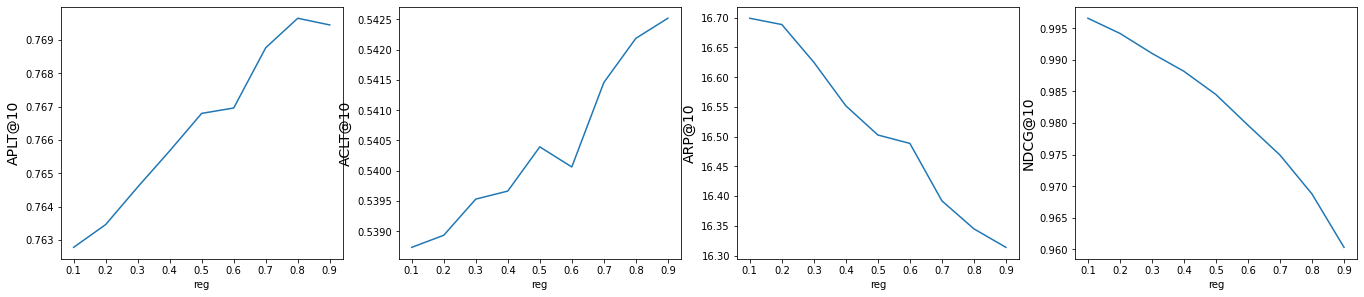

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
# plt.figure(figsize=(20,20))
plt.subplots_adjust(right=3, top=1, left=0)

sns.lineplot(x='reg', y='APLT@10', data=smooth_df, ax=ax1)
ax1.set_ylabel('APLT@10', fontsize=14)
sns.lineplot(x='reg', y='ACLT@10', data=smooth_df, ax=ax2)
ax2.set_ylabel('ACLT@10', fontsize=14)
sns.lineplot(x='reg',y='ARP@10', data=smooth_df, ax=ax3)
ax3.set_ylabel('ARP@10', fontsize=14)
sns.lineplot(x='reg', y='NDCG@10', data=smooth_df, ax=ax4)
ax4.set_ylabel('NDCG@10', fontsize=14)

### Binary XQuAD

In [ ]:
bin_scores = []
for reg in np.arange(0.1, 1, 0.1):
  ranked_top_n = defaultdict(list)

  for raw_uid, recommend_list in top_n_100.items():
    inner_uid = sp_train_set.to_inner_uid(raw_uid)
    user_profile = sp_train_set.ur[inner_uid]
    ranked_top_n[raw_uid] = re_rank(recommend_list, user_profile, short_items, long_items, sp_train_set, reg=reg, binary=True)

  ndcg = average_ndcg_at_k(ranked_top_n, top_n_10)
  score = get_score(ranked_top_n, sp_train_set, sp_test_set, long_items)
  bin_scores.append((reg, score[0], score[1], score[2], ndcg, 'binary'))
  print(score, ndcg)

(15.791526253981024, 0.7844912593103225, 0.5481663566303481) 0.9854057073606015
(14.8884301542625, 0.8064052118636039, 0.5583311187882009) 0.9718938008743743
(13.98678158168509, 0.8283593735041419, 0.5704225352112676) 0.9577540960111086
(13.179825409590194, 0.8458905355467686, 0.5802551155992559) 0.9463034419188942
(12.544360994632404, 0.8615318704884688, 0.588958277969705) 0.9356097579623233
(12.015571288158744, 0.8731522967047979, 0.5961998405527504) 0.9259355394359589
(11.591083954021226, 0.882842686732949, 0.6030427850119585) 0.9179698239546312
(11.315330033635222, 0.8891957225190389, 0.607759766144034) 0.9107549611407939
(11.11307832474901, 0.89297537672089, 0.6106829657188414) 0.9042251298988383


In [ ]:
binary_df = pd.DataFrame(bin_scores, columns=['reg', 'ARP@10', 'APLT@10', 'ACLT@10', 'NDCG@10', 'type'])
binary_df.to_csv(FILE_PATH + '/data/dataframe/ranking_binary_xquad.csv', index=False)

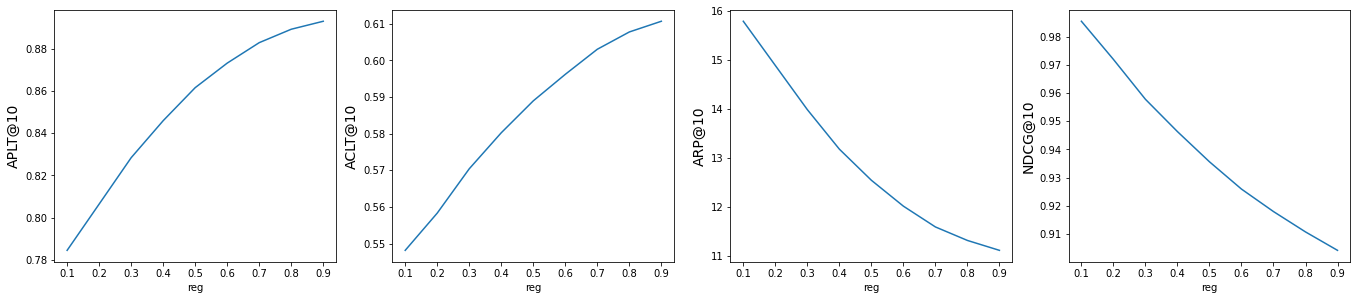

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
# plt.figure(figsize=(20,20))
plt.subplots_adjust(right=3, top=1, left=0)
ax1.set_ylabel('APLT@10', fontsize=14)
ax2.set_ylabel('ACLT@10', fontsize=14)
ax3.set_ylabel('ARP@10', fontsize=14)
ax4.set_ylabel('NDCG@10', fontsize=14)

sns.lineplot(x='reg', y='APLT@10', data=binary_df, ax=ax1)
sns.lineplot(x='reg', y='ACLT@10', data=binary_df, ax=ax2)
sns.lineplot(x='reg',y='ARP@10', data=binary_df, ax=ax3)
sns.lineplot(x='reg', y='NDCG@10', data=binary_df, ax=ax4)


,reg,ARP@10,APLT@10,ACLT@10,NDCG@10,type
0,0.1,16.699086,0.762778,0.538732,0.996565,smooth
1,0.2,16.688470,0.763462,0.538932,0.994174,smooth
2,0.3,16.625061,0.764588,0.539530,0.991016,smooth
3,0.4,16.551800,0.765673,0.539663,0.988172,smooth
4,0.5,16.502704,0.766799,0.540393,0.984492,smooth
5,0.6,16.488551,0.766960,0.540061,0.979651,smooth
6,0.7,16.391969,0.768770,0.541456,0.974922,smooth
7,0.8,16.344844,0.769654,0.542187,0.968759,smooth
8,0.9,16.313722,0.769453,0.542519,0.960324,smooth
0,0.1,15.791526,0.784491,0.548166,0.985406,binary


# Summary

## Accuracy Metric Summary

In [ ]:
accuracy_df = pd.read_csv(FILE_PATH + '/data/dataframe/rmse_mae.csv')

In [ ]:
# accuracy_summary = [('User-based KNN', user_knn_rmse, user_knn_mae),
#                     ('Item-based KNN', item_knn_rmse, item_knn_mae),
#                     ('SVD', svd_rmse, svd_mae),
#                     ('ALS', als_rmse, als_mae)]

# accuracy_df = pd.DataFrame(accuracy_summary, columns=['Name', 'RMSE', 'MAE'])
# accuracy_df.to_csv(FILE_PATH + '/data/dataframe/rmse_mae.csv', index=False)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 4000x2000 with 0 Axes>

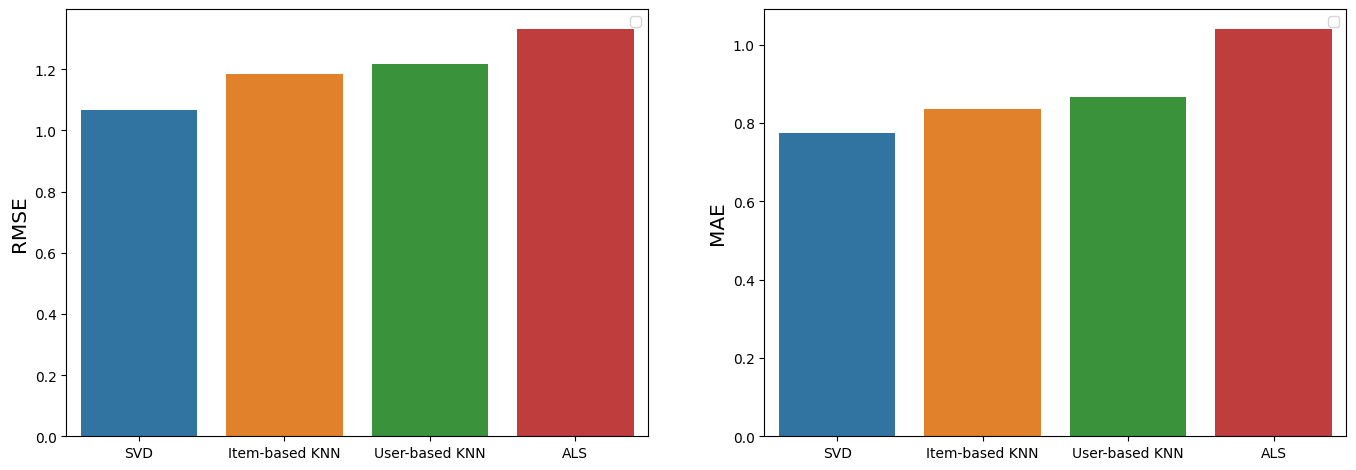

In [ ]:
plt.figure(figsize=(10,5), dpi=400)
fig, (ax1,ax2) = plt.subplots(1,2)
plt.subplots_adjust(right=2, top=1, left=0)
sns.barplot(y='RMSE', x='Name', data=accuracy_df.sort_values(by='RMSE', ascending=True), ax=ax1)
sns.barplot(y='MAE', x='Name', data=accuracy_df.sort_values(by='MAE', ascending=True), ax=ax2)

for ax in (ax1, ax2):
  handles, labels = ax.get_legend_handles_labels()
  ax.legend(handles=handles[1:], labels=labels[1:], loc=1)
  ax.set_xlabel('')
  ax.set_ylabel(ax.get_ylabel(), size='x-large')

## Ranking Metrics Summary

### F1 Score

In [ ]:
  k = 20
  item_knn_pr = list(item_knn.compute_precision_recall_at_k(k, THRESHOLD))
  user_knn_pr = list(user_knn.compute_precision_recall_at_k(k, THRESHOLD))
  svd_pr = list(svd.compute_precision_recall_at_k(k, THRESHOLD))
  als_precision, als_recall, als_f1 = pyspark_precision_recall_at_k(user_est, k)

  item_knn_f1 = item_knn.compute_f1()
  user_knn_f1 = user_knn.compute_f1()
  svd_f1 = svd.compute_f1()

In [ ]:
scores_data = item_knn_scores | user_knn_scores | als_scores | svd_scores
scores_df = pd.DataFrame(scores_data, columns=['Name', 'K', 'Precision', 'Recall', 'F1'])

plt.figure(figsize=(16,8))
plt.title('F1 Score over K')
plt.ylim(bottom=0.8, top=1)
sns.barplot(x='K', y='F1', hue='Name', data=scores_df)
plt.xlabel(k)


### Precision@K, Recall@K

In [ ]:
p_r_df = pd.concat([item_knn_scores_df, user_knn_scores_df, svd_scores_df, als_scores_df], axis=0)
p_r_df.to_csv(FILE_PATH + '/data/dataframe/p_and_r.csv', index=False)

In [ ]:
p_r_df = pd.read_csv(FILE_PATH + '/data/dataframe/p_and_r.csv')
p_r_df.columns = ['name', 'k', 'Precision@K', 'Recall@K', 'F1@K']
p_r_df = p_r_df.query('k < 30')

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi=1000)
plt.subplots_adjust(right=3, top=1, left=0)
sns.lineplot(x='k', y='Precision@K', hue='name', style='name', markers=['o','v','s','d'], data=p_r_df, ax=ax1)
sns.lineplot(x='k', y='Recall@K', hue='name', style='name', markers=['o','v','s','d'], data=p_r_df, ax=ax2)
sns.lineplot(x='k', y='F1@K', hue='name', style='name', markers=['o','v','s','d'], data=p_r_df, ax=ax3)

# remove label
for ax in (ax1, ax2, ax3):
  handles, labels = ax.get_legend_handles_labels()
  ax.legend(handles=handles[1:], labels=labels[1:], loc=1)
  ax.grid(False)
  loc = plticker.MultipleLocator(base=5) # this locator puts ticks at regular intervals
  ax.xaxis.set_major_locator(loc)

In [ ]:
p_r_df = p_r_df.query('k < 30')
p_r_df

,name,k,precision,recall,f1
0,item-knn,15,0.813378,0.908039,0.858106
2,item-knn,20,0.813176,0.909684,0.858727
3,item-knn,5,0.813936,0.821120,0.817512
4,item-knn,10,0.813385,0.899482,0.854270
5,user-knn,5,0.824812,0.837675,0.831194
6,user-knn,15,0.822011,0.918416,0.867544
7,user-knn,10,0.822388,0.910992,0.864425
9,user-knn,20,0.821916,0.919692,0.868060
10,svd,5,0.877214,0.701618,0.779651
11,svd,15,0.874018,0.761199,0.813716


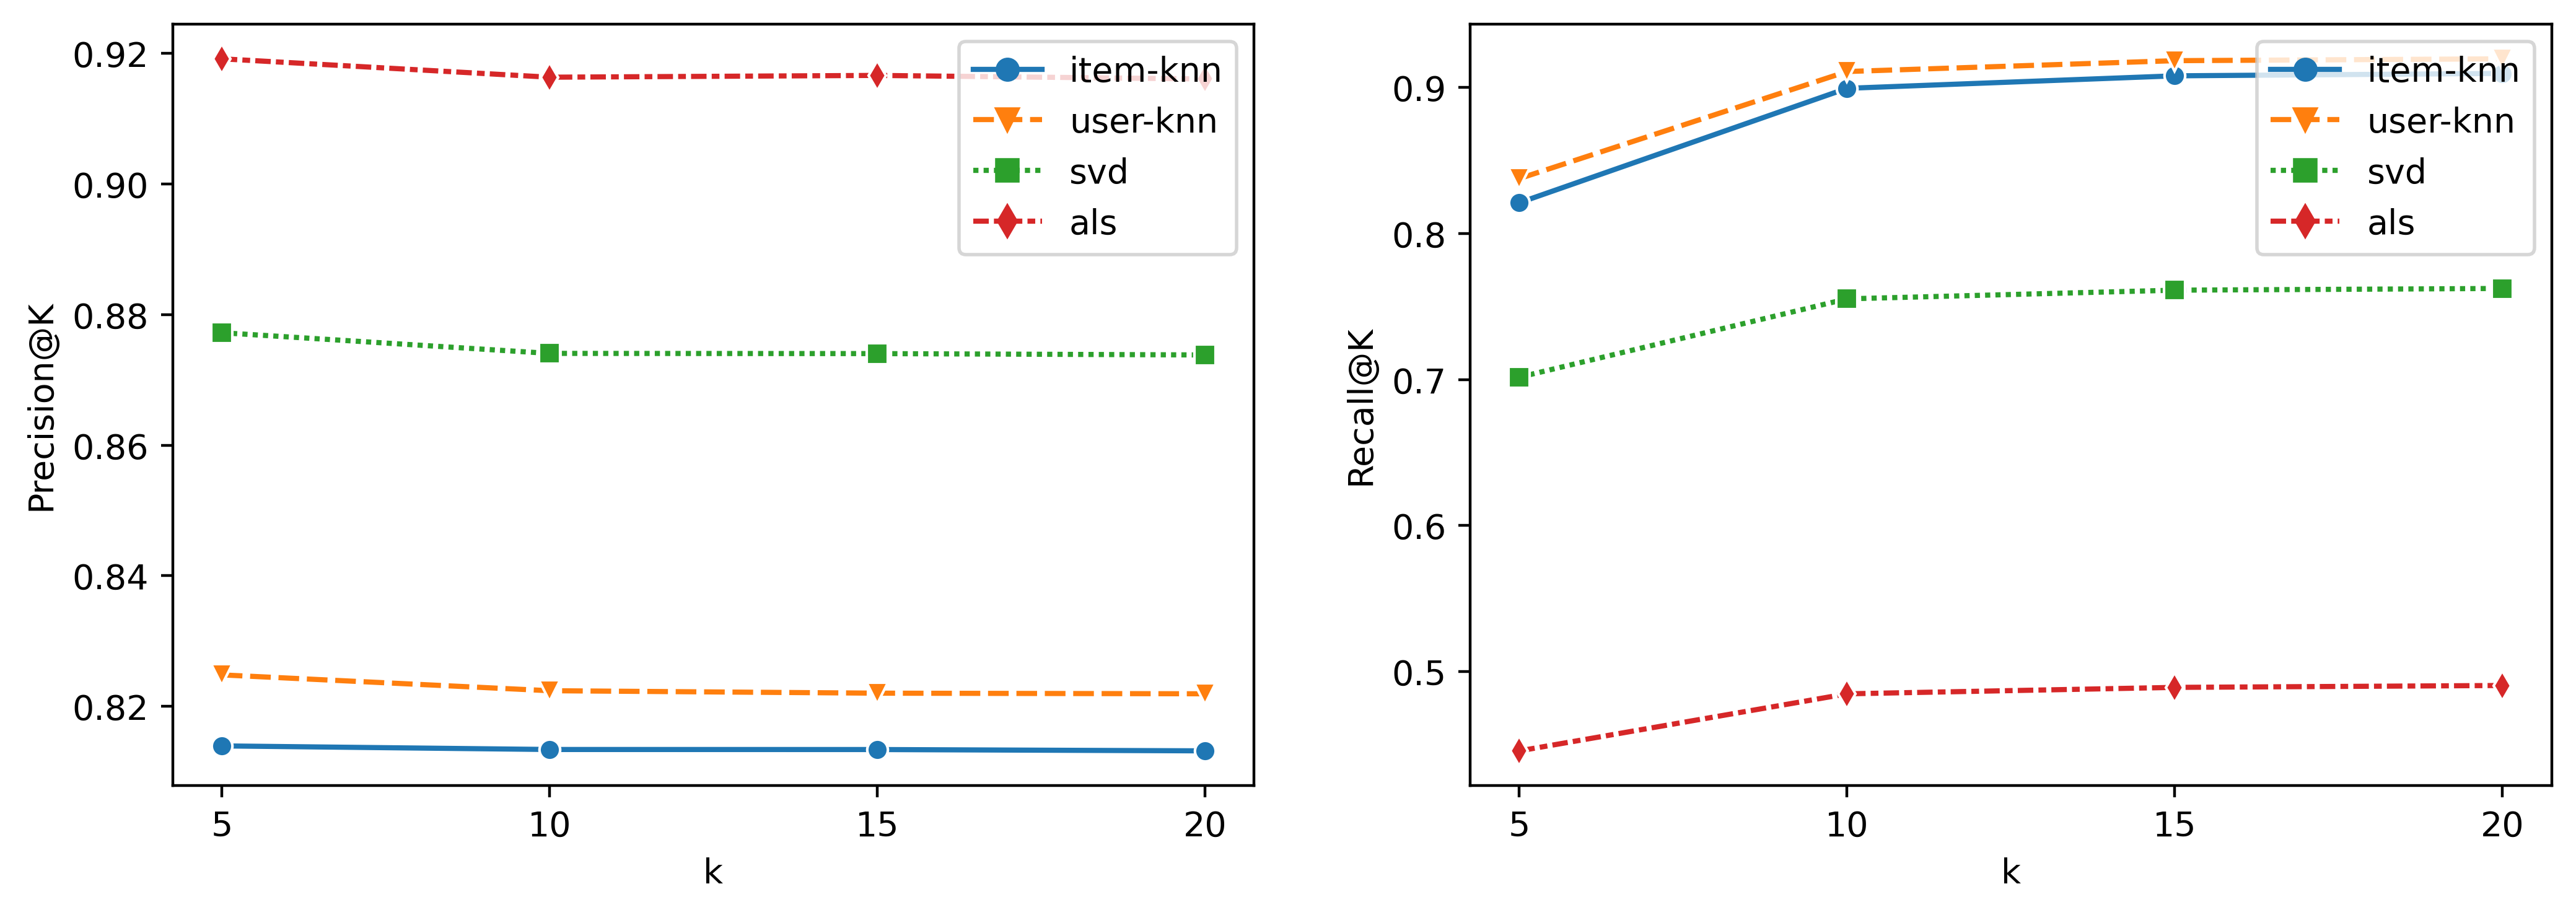

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=400)
plt.subplots_adjust(right=1.5, top=.75, left=0)

sns.lineplot(x='k', y='precision', hue='name', style='name', markers=['o','v','s','d'], data=p_r_df, ax=ax1)
sns.lineplot(x='k', y='recall', hue='name', style='name', markers=['o','v','s','d'], data=p_r_df, ax=ax2)

ax1.set_ylabel('Precision@K')
ax2.set_ylabel('Recall@K')

# remove label
for ax in (ax1, ax2):
  handles, labels = ax.get_legend_handles_labels()
  ax.legend(handles=handles[1:], labels=labels[1:], loc=1)
  ax.grid(False)
  loc = plticker.MultipleLocator(base=5) # this locator puts ticks at regular intervals
  ax.xaxis.set_major_locator(loc)

# sns.lineplot(x='k', y='f1', hue='name', marker='o', data=p_r_df, ax=ax3)

In [ ]:
fig, (ax) = plt.subplots(1, 1, dpi=200)
sns.lineplot(x='k', y='f1', hue='name', style='name', markers=['o','v','s','d'], data=p_r_df, ax=ax)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc=1)

ax.set_ylabel('F1@K')
loc = plticker.MultipleLocator(base=5) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)


### ARP, APLT, ACLT
Average Recommendation Popularity, Average Percentage of Long Tail items, Average Coverage of Long Tail Items 

In [ ]:
ranking_summary = pd.concat([binary_df, smooth_df], axis=0)
ranking_summary.to_csv(FILE_PATH + '/data/dataframe/ranking_xquad.csv', index=False)

In [ ]:
ranking_summary

In [ ]:
hue = 'type'
smooth_binary_df = pd.read_csv(FILE_PATH + '/data/dataframe/ranking_xquad.csv', header=0)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi=1000)
plt.subplots_adjust(right=3, top=1, left=0)

sns.lineplot(x='reg', y='APLT@10', hue=hue, style=hue, markers=['o','s'], data=smooth_binary_df, ax=ax1)
sns.lineplot(x='reg', y='ACLT@10', hue=hue, style=hue, markers=['o','s'], data=smooth_binary_df, ax=ax2)
sns.lineplot(x='reg', y='ARP@10', hue=hue, style=hue, markers=['o','s'], data=smooth_binary_df, ax=ax3)

for ax in (ax1, ax2, ax3):
  handles, labels = ax.get_legend_handles_labels()
  ax.legend(handles=handles[1:], labels=labels[1:], loc=1)

# sns.lineplot(x='reg', y='ARP@10', hue=hue, marker='o', data=smooth_binary_df, ax=ax3)

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=200)
sns.lineplot(x='reg', y='ARP@10', hue=hue, style=hue, markers=['o','s'], data=smooth_binary_df, ax=ax)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc=1)

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=200)
sns.lineplot(x='reg', y='NDCG@10', hue=hue, style=hue, markers=['o','s'], data=smooth_binary_df, ax=ax)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc=1)

## Matching Recommendation between Algorithms

In [ ]:
def matched_recommendations(pred1, pred2):
  hash_table = {}

  for p1 in pred1:
    if p1 in hash_table:
      hash_table[p1] += 1
    else:
      hash_table[p1] = 1

  count = 0
  for p2 in pred2:
    if p2 in hash_table:
      count += 1
  return count

print(f'Matching recommendations for Item-KNN and SVD: {matched_recommendations(i_knn_rec, svd_rec)}')
print(f'Matching recommendations for Item-KNN and ALS: {matched_recommendations(i_knn_rec, als_rec_list)}')
print(f'Matching recommendations for Item-KNN and User-based KNN: {matched_recommendations(i_knn_rec, u_knn_rec)}')

print(f'Matching recommendations for User-KNN and SVD: {matched_recommendations(u_knn_rec, svd_rec)}')
print(f'Matching recommendations for User-KNN and ALS: {matched_recommendations(u_knn_rec, als_rec_list)}')

print(f'Matching recommendations for SVD and ALS: {matched_recommendations(svd_rec, als_rec_list)}')


Matching recommendations for Item-KNN and SVD: 0
Matching recommendations for Item-KNN and ALS: 1
Matching recommendations for Item-KNN and User-based KNN: 22
Matching recommendations for User-KNN and SVD: 0
Matching recommendations for User-KNN and ALS: 3
Matching recommendations for SVD and ALS: 1


## Prediction Rating Distribution

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

# get dataframes for ploting
columns = ['uid', 'iid', 'rui', 'est', 'details']
df_svd = pd.DataFrame(svd.predictions, columns=columns)   
df_i_knn = pd.DataFrame(item_knn.predictions, columns=columns)
df_u_knn = pd.DataFrame(``user_knn.predictions, columns=columns)
df_als = pd.read_csv('/content/drive/My Drive/thesis/data/dataframe/als_prediction.csv', header=0)
true_rating = pd.DataFrame(sp_test_set, columns=['item','user','rating'])

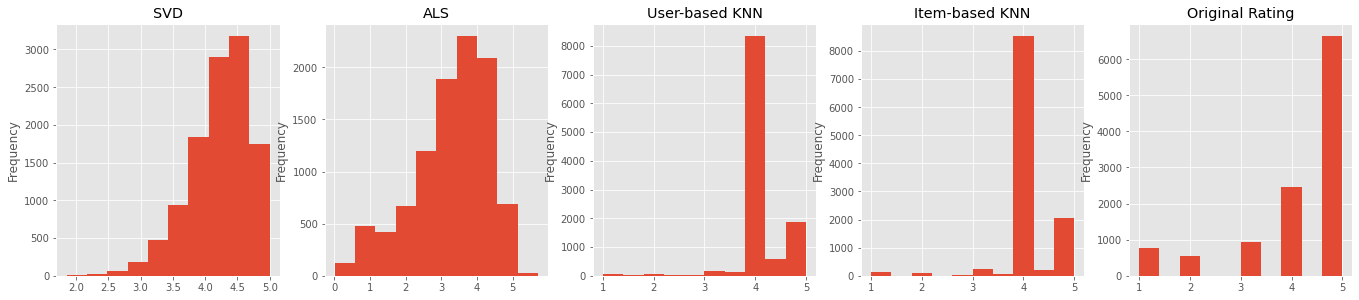

In [ ]:
figure, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)
plt.subplots_adjust(right=3, top=1, left=0)

df_svd.est.plot(kind='hist', title='SVD', ax=ax1)
df_als.prediction.plot(kind='hist', title='ALS', ax=ax2)
df_u_knn.est.plot(kind='hist', title='User-based KNN', ax=ax3)
df_i_knn.est.plot(kind='hist', title='Item-based KNN', ax=ax4)

true_rating.rating.plot(kind='hist', title='Original Rating', ax=ax5)

# End-user Simulation


User to test: **A3KOASATK1KTI**

In [ ]:
# load data from csv
sp_data = pd.read_csv(data_path, header=0)

# convert to surprise Dataset
reader = Reader()
sp_raw_data = Dataset.load_from_df(sp_data, reader=reader)
sp_train, sp_test = train_test_split(sp_raw_data, test_size=TEST_SIZE, random_state=SEED)

# build full trainset, testset for top-N recommendation
sp_train_set = sp_raw_data.build_full_trainset()
sp_test_set = sp_train_set.build_testset()

In [ ]:
svd_model = IncrementalSVD(n_factors=20, n_epochs=100, lr_all=0.005, reg_all=.1, random_state=SEED)
svd_model.fit(sp_train)
preds = svd_model.test(sp_test)
rmse(preds)

In [ ]:
dump.dump(model_path + 'insvd_82', algo=svd_model, predictions=preds)

In [ ]:
class RecSys:
    """A wrapper class to load pre-trained `surprise` model and making predictions.
    Attributes:
         predictions (tuple): Tuple of (user_id, item_id, true_rating, estimated_rating, details)
         model: Pre-trained model
    """

    def __init__(self, model_path):
        """Init RecSys
        Args:
            model_path (str): Model path
        """
        # load prediction and model from a given file
        self.predictions, self.model = dump.load(model_path)

        self.avg_recall = 0
        self.avg_precision = 0

    def recommend(self, raw_uid, k=50):
        """Return top-K recommendations for a user.

        Args:
            raw_uid (str): Raw user id then it will be converted to inner id of the model.
            k (int): Number of recommendations.
        """
        # exclude items that user has rated
        inner_uid = self.model.trainset.to_inner_uid(raw_uid)
        user_profile = self.model.trainset.ur[inner_uid]
        rated_items = set([inner_iid for inner_iid, _ in user_profile])

        recommendations = []

        # looping through each item in train set, predict the rating of each pair of item and user
        for iid in self.model.trainset.all_items():
            # excluding items already rated by user
            if iid in rated_items:
                continue

            rid = self.model.trainset.to_raw_iid(iid)
            prediction = self.model.predict(raw_uid, rid)

            # only consider rating that are larger or equal than 3
            if prediction.est >= 3:
              recommendations.append((rid, prediction.est))

        # sort by rating
        recommendations.sort(key=lambda x: x[1], reverse=True)
        return recommendations[:k]
    
    def get_user_ratings_from_trainset(self, raw_uid):
      return [[trainset.to_raw_iid(r[0]), r[1]] for r in self.model.trainset.ur[self.model.trainset.to_inner_uid(raw_uid)]]

    def get_user_ratings_from_testset(self, raw_uid):
      return [r for r in self.predictions if r[0] == raw_uid]

    def get_short_head_and_long_tail_items(self, threshold):
        """Returns the short head and long tail items as a tuple.
        Args:
            threshold (int): If user's number of ratings larger than the threshold, it is in short-head.
             Else, it is in long-tail.
        """
        # using set for faster look-up time
        short_head_items = set()
        long_tail_items = set()


        for inner_iid, ratings in self.model.trainset.ir.items():
            raw_iid = self.model.trainset.to_raw_iid(inner_iid)
            if len(ratings) >= threshold:
                short_head_items.add(raw_iid)
            else:
                long_tail_items.add(raw_iid)

        return short_head_items, long_tail_items

    def compute_precision_recall_at_k(self, k=20, threshold=3.0):
        """Return precision and recall @K of current model
        Args:
            k (int): Number of K to stop.
            threshold (float): Minimum rating for a product to be considered as "relevant"
        """
        precisions, recalls = precision_recall_at_k(self.predictions, k=k, threshold=threshold)

        self.avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
        self.avg_recall = sum(rec for rec in recalls.values()) / len(recalls)

        return self.avg_precision, self.avg_recall


In [ ]:
rs = RecSys('/content/drive/My Drive/thesis/model/clean/insvd_82')
predictions = rs.predictions
trainset = rs.model.trainset
model = rs.model

In [ ]:
hit = 0
total = 0

for inner_uid in trainset.all_users():
  raw_uid = trainset.to_raw_uid(inner_uid)
  recommendations = rs.recommend(raw_uid, k=100)
  test_recommendations = set([p.iid for p in predictions if p.r_ui >= 3.0])
  
  for raw_iid, _ in recommendations:
    if raw_iid in test_recommendations:
      hit += 1

  total += 1

In [ ]:
hit, (hit/total * 100)

(140782, 56.6267386390147)

In [ ]:
from collections import defaultdict

true_interest = defaultdict(set)
for uid, iid, true_r, est, _ in predictions:
  if true_r >= 3.0:
    true_interest[uid].add(iid)
number_of_all_relevant_items = len(list(true_interest.values()))

In [ ]:
short_head_items, long_tail_items = recsys.get_short_head_and_long_tail_items(threshold=20)
total_hits = dict()

for inner_uid in trainset.all_users():
  raw_uid = trainset.to_raw_uid(inner_uid)
  user_profile = trainset.ur[inner_uid]

  recommendations = re_rank(rs.recommend(raw_uid, k=100), user_profile, short_head_items, long_tail_items, trainset,
                            n_epochs=10, reg=0.1, binary=True)
  hits = sum((raw_iid in true_interest[raw_uid]) for raw_iid, _ in recommendations)
  total_hits[raw_uid] = hits      

In [ ]:
sum(list(total_hits.values())) / number_of_all_relevant_items

0.009954375777685608

In [ ]:
import numpy as np
total_hits_list = []

for k in np.arange(50, 250, 50):
  total_hits = dict()

  for inner_uid in trainset.all_users():
    raw_uid = trainset.to_raw_uid(inner_uid)
    user_profile = trainset.ur[inner_uid]

    recommendations = re_rank(rs.recommend(raw_uid, k=k*2), user_profile, short_head_items, long_tail_items, trainset,
                              n_epochs=k, reg=0.1, binary=True)
    hits = sum((raw_iid in true_interest[raw_uid]) for raw_iid, _ in recommendations)
    total_hits[raw_uid] = hits      

  total_hits_list.append((k, sum(list(total_hits.values())) / number_of_all_relevant_items))
  print(f'Total hits at {k}:', sum(list(total_hits.values())))
  print(f'Recall at {k}:', sum(list(total_hits.values())) / number_of_all_relevant_items)


Total hits at 50: 65
Recall at 50: 0.026959767731231855
Total hits at 100: 120
Recall at 100: 0.04977187888842804
Total hits at 150: 169
Recall at 150: 0.07009539610120281
Total hits at 200: 230
Recall at 200: 0.09539610120282041


In [ ]:
print(list(map(lambda x: x*100, total_hits_list)))

[0.9248090068355449, 2.613590671491757, 4.8250904704463204]


In [ ]:
ks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
total_hits_tolist = list(map(lambda x: x*100, total_hits_list))
total_hits_and_ks = [(ks[i], hit) for i, hit in enumerate(total_hits_tolist)]
total_hits_and_ks_df = pd.DataFrame(total_hits_and_ks, columns=['k', 'Hit Rate (%)'])

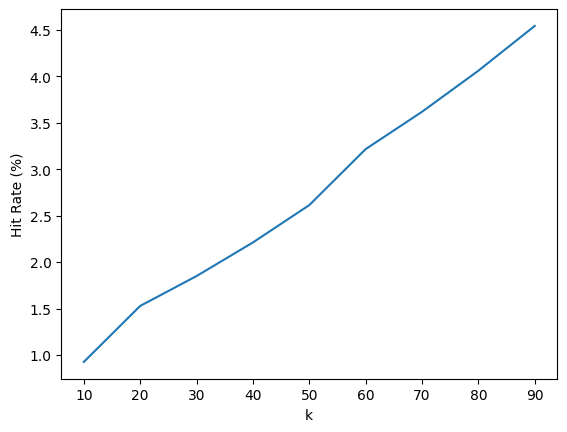

In [ ]:
lp = sns.lineplot(x='k', y='Hit Rate (%)', data=total_hits_and_ks_df)

In [ ]:
lp.get_figure().savefig('hit-rate.png',dpi=400)

In [ ]:
# Get the short head and long tail items for re-ranking the recommendation list.
short_head_items, long_tail_items = recsys.get_short_head_and_long_tail_items(threshold=20)

# Get the recommendations then re-rank using xQuAD algorithm
inner_uid = recsys.model.trainset.to_inner_uid(user_id)
user_profile = recsys.model.trainset.ur[inner_uid]

In [ ]:
recommendations = re_rank(rating_in_recommendation, user_profile, short_head_items, long_tail_items,
                          recsys.model.trainset, n_epochs=100, reg=0.1, binary=True)

In [ ]:
match = 0
for rating in rating_in_recommendation:
  if rating[0] in rating_in_test:
    print(rating[0])
    match += 1
print(f'Total match: {match} of {len(rating_in_test)}')

B000ZMCILW
Total match: 1 of 11
